In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="C:/windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

test = pd.read_csv("D:/전력예측/전처리test.csv", encoding='euc-kr')
train = pd.read_csv("D:/전력예측/train_cluster.csv",encoding='euc-kr')

In [ ]:
train = train[['클러스터4','기온','풍속','습도','강수량','일조','비전기냉방설비운영','태양광보유','시간','주말','체감온도','불쾌지수','target']]

def cluster1(df):
    df['주간그룹'] = None
    df['야간그룹'] = None

    df['주간그룹'] = (df['시간'] >= 7) & (df['시간'] <= 18)
    df['주간그룹'] = df['주간그룹'].astype(int)

    df['야간그룹'] = (df['시간'] < 7) | (df['시간'] > 18)
    df['야간그룹'] = df['야간그룹'].astype(int)
    
    #df.drop(columns=['클러스터','date_time','연도','일','요일','월'],inplace=True)
    
    df = pd.get_dummies(df, columns=['클러스터4','비전기냉방설비운영', '태양광보유','주말'])
    
    return df 

train = cluster1(train)

#### 전력사용량이 제대로 조인됐는지 확인

In [2]:
new = pd.read_csv("D:/전력예측/전처리train.csv", encoding='euc-kr')
sum(new['전력사용량']-train['target'])

0.0

### 클러스터별 데이터프레임 분할

In [6]:
train1 = train[train['클러스터4']==1]
train2 = train[train['클러스터4']==2]
train3 = train[train['클러스터4']==3]
train4 = train[train['클러스터4']==4]

In [7]:
for i in range(1, 5):
    train = globals()['train{}'.format(i)]
    print('train{} - 클러스터: {}, 건물 개수: {}'.format(i, train['클러스터4'].unique(), len(train['건물번호'].unique())))

train1 - 클러스터: [1], 건물 개수: 32
train2 - 클러스터: [2], 건물 개수: 7
train3 - 클러스터: [3], 건물 개수: 5
train4 - 클러스터: [4], 건물 개수: 16


In [9]:
train.head(1)

,건물번호,클러스터4,클러스터,date_time,전력사용량,기온,풍속,습도,강수량,일조,...,태양광보유,연도,월,일,시간,요일,주말,체감온도,불쾌지수,target
6120,4,4,2,2020-06-01 00:00:00,-0.840376,22.6,0.7,62.0,0.0,0.0,...,1.0,2020,6,1,0,월,0,24.890433,565.194,339.552


## 1. 클러스터1에 대한 회귀분석

### 사전 과정 

- 연속형 변수 간의 산점도 확인
- 범주형 변수 상관 확인
- 정규성 확인

(1) 로그변환 시도

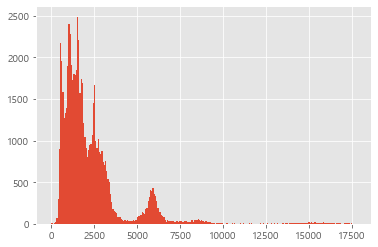

In [39]:
plt.hist(train1['target'],bins=50)
plt.show();

In [14]:
train1['target'] = np.log1p(train1['target'])

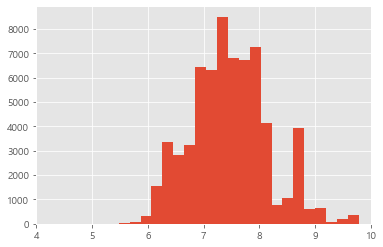

In [46]:
plt.hist(train1['target'],bins=50)
plt.xlim([4,10])
plt.show();

### 결정계수를 높이기 위한 전처리

In [ ]:
train

## 군집1에 대한 모델링

In [13]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def cluster1(df):

    df['주간그룹'] = None
    df['야간그룹'] = None

    df['주간그룹'] = (df['시간'] >= 7) & (df['시간'] <= 18)
    df['주간그룹'] = df['주간그룹'].astype(int)

    df['야간그룹'] = (df['시간'] < 7) | (df['시간'] > 18)
    df['야간그룹'] = df['야간그룹'].astype(int)
    
    df.drop(columns=['클러스터','date_time','연도','일','요일','월'],inplace=True)
    
    df = pd.get_dummies(df, columns=['비전기냉방설비운영', '태양광보유','주말'])
    
    return df 

train1 = cluster1(df=train1)

In [37]:
train1.head()

,건물번호,클러스터4,전력사용량,기온,풍속,습도,강수량,일조,시간,체감온도,불쾌지수,target,주간그룹,야간그룹,비전기냉방설비운영_0.0,비전기냉방설비운영_1.0,태양광보유_0.0,태양광보유_1.0,주말_0,주말_1
2040,2,1,-0.958833,18.3,2.5,94.0,0.0,0.0,0,19.729799,419.921,977.184,0,1,0,1,1,0,1,0
2041,2,1,-0.991562,18.8,2.3,89.0,0.0,0.0,1,20.330190,445.296,966.168,0,1,0,1,1,0,1,0
2042,2,1,-0.971347,19.0,3.2,86.0,0.0,0.0,2,20.307253,449.550,972.972,0,1,0,1,1,0,1,0
2043,2,1,-0.992524,19.0,4.1,85.0,0.0,0.0,3,20.120321,445.040,965.844,0,1,0,1,1,0,1,0
2044,2,1,-0.975198,18.9,3.9,87.0,0.0,0.0,4,20.047195,445.366,971.676,0,1,0,1,1,0,1,0


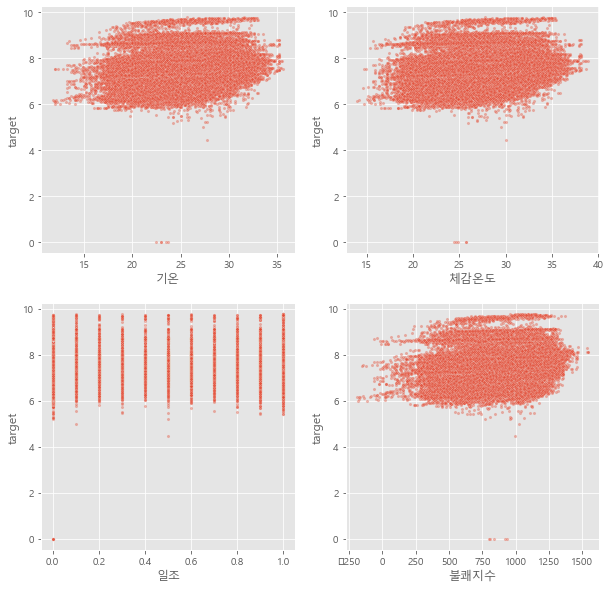

In [47]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.scatterplot(x='기온',y='target',data=train1,alpha=0.4,s=10)

plt.subplot(2,2,2)
sns.scatterplot(x='체감온도',y='target',data=train1,alpha=0.4,s=10)

plt.subplot(2,2,3)
sns.scatterplot(x='일조',y='target',data=train1,alpha=0.4,s=10)

plt.subplot(2,2,4)
sns.scatterplot(x='불쾌지수',y='target',data=train1,alpha=0.4,s=10)
plt.show()

### 회귀 시작
- 평가지표 함수 생성
- 트레인, 테스트 스플릿
- 선형회귀

#### 우리가 고려하지 않기로 한 변수: 건물번호, 클러스터4, 시간

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))

In [29]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = train1['target']
X_features = train1.drop(['target','전력사용량','건물번호','클러스터4','시간'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSE: 0.615, MAE: 0.475


In [30]:
import statsmodels.api as sm

# OLS 검정
model = sm.OLS(y_train, X_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     1171.
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:48:36   Log-Likelihood:                -42590.
No. Observations:               45696   AIC:                         8.520e+04
Df Residuals:                   45684   BIC:                         8.531e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
기온                0.0480      0.008      5.733

- 첨도, 왜도 만족
- 결정계수 너무 낮음
- 강수량, 일조, 불쾌지수 t검정 불만족

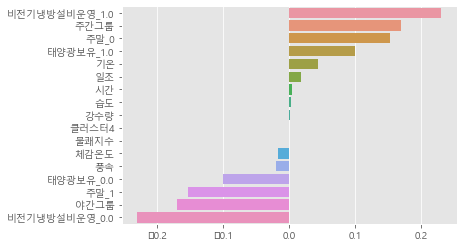

In [18]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

### 결정계수가 매우 낮음. 따라서 다음과 같은 조치가 필요할 것으로 보임
- VIF 확인 -> PCA를 통해 해결 or 릿지회귀 or 라쏘회귀 적용 -> 파이프라인을 만들어 한 번에 적용해볼 연습
     - PCA: 다중공선성이 높은 변수들 간에 상관이 높을 경우, PCA를 통해 이들을 1, 2개의 컬럼으로 차원축소
     - 릿지회귀: L2 정규화를 사용하여 회귀 계수들이 너무 커지지 않도록 제한. 즉, 다중 공선성 문제를 해결하고, 모델의 일반화 성능을 개선
     - 라쏘회귀:  L1 정규화를 사용하여 일부 회귀 계수들을 0으로 만듦. 이를 통해 변수 선택(feature selection)을 수행하고, 모델을 더 간단하게 만들어 과적합(overfitting)을 방지
     
- 회귀계수가 높은 변수에 대한 이상치 탐색
- 각 독립변수의 정규성 확인 
- 건물번호 컬럼을 원핫인코딩 후, 회귀계수 확인 -> 영향력이 큰 건물번호를 따로 검출해 따로 회귀분석

#### 이상치 제거
- 건물번호 31, 33일 때, 목요일에 이상값 존재
- target값과 기온 산점도를 살펴볼 때, target값이 0에 근사한 값 다수 존재

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
print(vif[~np.isinf(vif['VIF Factor'])].sort_values(by='VIF Factor',ascending=False))

   VIF Factor features
1   99.572171       기온
7   56.655393     체감온도
8   21.585014     불쾌지수
3   12.441166       습도
5    2.254557       일조
2    1.515866       풍속
6    1.164778       시간
4    1.079960      강수량
0    0.000000    클러스터4


#### 기온, 습도, 체감온도, 불쾌지수 높은 VIF
#### 따라서 4개 변수간의 상관 먼저 확인

In [20]:
train1[['기온','습도','체감온도','불쾌지수']].corr()

,기온,습도,체감온도,불쾌지수
기온,1.000000,-0.518398,0.987182,0.753812
습도,-0.518398,1.000000,-0.502450,0.136818
체감온도,0.987182,-0.502450,1.000000,0.745218
불쾌지수,0.753812,0.136818,0.745218,1.000000


#### 기온과 체감온도, 불쾌지수 간에 높은 상관을 가짐

#### 산점도에서 target값이 0인 이상치들이 몇몇 존재